# Análisis exploratorio de los datos.

Conjunto de datos *Mexican Sign Language Alphabet (signos estáticos)* contiene una serie de imágenes estáticas que representan el alfabeto de la Lengua de Señas Mexicana (LSM). Este conjunto incluye un total de 21 signos, excluyendo las letras J, K, Ñ, Q, X y Z, ya que estas se representan mediante movimientos dinámicos en LSM.

**Recolección y Representación de los Datos:**

Las imágenes fueron capturadas con un fondo verde uniforme y en condiciones de iluminación controlada para garantizar la consistencia visual. Cada imagen tiene una resolución de 360 x 360 píxeles. La recopilación de datos involucró a 20 participantes, asegurando una representación diversa de las señas. Para cubrir una variedad de configuraciones, el conjunto se dividió en tres grupos según el grado de variación de las posturas:

- **Grupo A:** Rotaciones leves en todos los ejes.
- **Grupo B:** Rotaciones en los tres ejes (guiñada, cabeceo e inclinación).
- **Grupo C:** Variaciones significativas en todas las direcciones.

**División de los Datos:**

La distribución de imágenes para cada grupo es la siguiente:

- **Grupo A:** 92,703 imágenes en total, de las cuales 9,439 son para prueba y 83,264 para entrenamiento.
- **Grupo B:** 92,860 imágenes, con 8,841 para prueba y 84,019 para entrenamiento.
- **Grupo C:** 94,153 imágenes, de las cuales 9,339 son para prueba y 84,814 para entrenamiento.

**Totales:**

- Total de imágenes: **279,716**
- Total de imágenes para prueba: **27,619**
- Total de imágenes para entrenamiento: **252,097**

# Bibliotecas

In [1]:
# Librerías para manipulación de datos
import os
import re
import time
import pandas as pd
import numpy as np

# Librerías para la extracción de keypoint de las imágenes
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

# Librerías para la visualización de datos
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

# Librerías de Machine Learning de scikit-learn
from sklearn.model_selection import StratifiedShuffleSplit, cross_validate
from sklearn.metrics import make_scorer, f1_score, recall_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import GridSearchCV

# Otras herramientas
from joblib import dump
from collections import Counter


In [76]:
# from google.colab import drive
# drive.mount('/content/drive')

# Extraccion de caracteristicas

Este bloque de código establece la configuración para el detector de manos utilizando el modelo de MediaPipe.
Se configuran las opciones necesarias para el procesamiento de imágenes y la detección de manos.
Luego, se crea un objeto `HandLandmarker` que será utilizado para la detección de manos en imágenes.

In [79]:
# Definir el modo de ejecución de la visión
VisionRunningMode = mp.tasks.vision.RunningMode  # Establece el modo en que el modelo procesará las imágenes (en este caso, una por una, de forma estática).

# Establecer las opciones base para el modelo de detección de manos
base_options = python.BaseOptions(model_asset_path='hand_landmarker.task')
# `model_asset_path`: La ruta al archivo del modelo de MediaPipe para detección de manos.

# Configuración de las opciones específicas para la detección de manos
options = vision.HandLandmarkerOptions(
    base_options=base_options,  # Opciones base que incluyen el modelo a usar.
    running_mode=VisionRunningMode.IMAGE,  # Modo de ejecución: "IMAGE" indica que el modelo procesará imágenes de manera estática.
    num_hands=1,  # Número máximo de manos a detectar en cada imagen.
    min_hand_detection_confidence=0.5,  # Umbral mínimo de confianza para detectar la mano en la imagen.
    min_hand_presence_confidence=0.5   # Umbral mínimo de confianza para considerar que hay una mano presente en la imagen.
)

# Crear el detector de manos con las opciones configuradas
detector = vision.HandLandmarker.create_from_options(options)  # Se crea un objeto detector a partir de las opciones configuradas anteriormente.


Esta función procesa un conjunto de datos dado, realizando la detección de manos en cada imagen, extrayendo las características de las manos, y guardando los resultados en archivos CSV. La función recibe como parámetros las rutas del dataset, el nombre del archivo de salida y el path raíz.

In [77]:
def process_dataset(dataset_paths, output_filename, root_path):
    # Definición de los nombres de las columnas que se usarán en el DataFrame
    nombres_columnas = ['WRIST_X', 'WRIST_Y', 'THUMB_CMC_X', 'THUMB_CMC_Y', 'THUMB_MCP_X', 'THUMB_MCP_Y',
                        'THUMB_IP_X', 'THUMB_IP_Y', 'THUMB_TIP_X', 'THUMB_TIP_Y', 'INDEX_MCP_X', 'INDEX_MCP_Y',
                        'INDEX_PIP_X', 'INDEX_PIP_Y', 'INDEX_DIP_X', 'INDEX_DIP_Y', 'INDEX_TIP_X', 'INDEX_TIP_Y',
                        'MIDDLE_MCP_X', 'MIDDLE_MCP_Y', 'MIDDLE_PIP_X', 'MIDDLE_PIP_Y', 'MIDDLE_DIP_X',
                        'MIDDLE_DIP_Y', 'MIDDLE_TIP_X', 'MIDDLE_TIP_Y', 'RING_MCP_X', 'RING_MCP_Y', 'RING_PIP_X',
                        'RING_PIP_Y', 'RING_DIP_X', 'RING_DIP_Y', 'RING_TIP_X', 'RING_TIP_Y', 'PINKY_MCP_X',
                        'PINKY_MCP_Y', 'PINKY_PIP_X', 'PINKY_PIP_Y', 'PINKY_DIP_X', 'PINKY_DIP_Y', 'PINKY_TIP_X',
                        'PINKY_TIP_Y']

    # Inicialización de las listas que almacenarán las características (X) y las etiquetas (y)
    X = []
    y = []

    # Inicialización de las listas que almacenarán la ruta de las imagenes donde no se detectaron manos
    warning = []


    # Iteración sobre cada ruta de dataset proporcionada
    for dataset_path in dataset_paths:
        # Variables temporales para almacenar los datos procesados de cada conjunto
        X_temp = []
        y_temp = []

        # Iteración sobre cada directorio (cada clase de señas)
        for directory in os.listdir(dataset_path):
            sign_path = os.path.join(dataset_path, directory)

            # Iteración sobre cada archivo (imagen) en el directorio
            for file in os.listdir(sign_path):
                file_path = os.path.join(sign_path, file)

                # Creación de la imagen a partir del archivo
                image = mp.Image.create_from_file(file_path)

                # Ejecución de la detección de manos
                detection_result = detector.detect(image)

                # Verificación si se detectaron manos en la imagen
                if detection_result.hand_landmarks:
                    # Extraer las coordenadas X, Y de las landmarks de la mano
                    df = pd.DataFrame(detection_result.hand_landmarks[0])
                    df = df.iloc[:, [0, 1]]  # Conservar solo las columnas X (0) y Y (1)

                    # Aplana las coordenadas de la mano y agrega a la lista de características
                    features = df.to_numpy().flatten()
                    X.append(features)  # Añadir características al conjunto global
                    y.append(directory)  # Añadir la clase (seña) al conjunto global

                    # Añade las características y etiqueta al conjunto temporal
                    X_temp.append(features)
                    y_temp.append(directory)

                else:
                    # Añade la ruta de la imagen a la lista de errores
                    warning.append(file_path)

        # Guardar los datos procesados del dataset parcial en un archivo CSV
        # Relativizar la ruta del dataset respecto al directorio raíz
        dataset_name = os.path.relpath(dataset_path, root_path)
        # Reemplazar las barras invertidas por guiones para evitar problemas con los nombres de archivo
        dataset_name = dataset_name.replace('\\', '-')

        # Crear un DataFrame temporal con las características y etiquetas
        df = pd.DataFrame(X_temp)
        # Renombrar las columnas del DataFrame con los nombres de características definidos
        df.columns = nombres_columnas
        # Añadir la columna 'LETRA' con las etiquetas (clases)
        df['LETRA'] = y_temp
        # Guardar el DataFrame como un archivo CSV
        df.to_csv(f"{dataset_name}.csv", index=False)

    # Guardar todo el dataset procesado (global) en un archivo CSV
    df = pd.DataFrame(X)
    # Renombrar las columnas con los nombres definidos
    df.columns = nombres_columnas
    # Añadir la columna de etiquetas (clases)
    df['LETRA'] = y
    # Guardar el dataset completo en el archivo de salida
    df.to_csv(output_filename, index=False)
    return warning


Este funcion analiza la lista de los errores en la deteccion de la mano por medipipe. El objetivo es identificar y contar las ocurrencias de ciertos pares de categorías (Tipo) y letras (Letra).

In [94]:
def warning_heatmap(warnings):
    # Verifica si la lista está vacía
    if not warnings:
        print("No hay errores en la lista")
        return

    # Expresión regular para extraer el tipo y la letra del texto de advertencia.
    pattern = r'lsm-abc-(\w)\\train\\(\w)'

    # Extrae los pares (tipo, letra) usando la expresión regular, si coincide.
    pairs = [re.search(pattern, line).groups() for line in warnings if re.search(pattern, line)]
    if not pairs:
        # Expresión regular para extraer el tipo y la letra del texto de advertencia.
        pattern = r'lsm-abc-(\w)\\test\\(\w)'

        # Extrae los pares (tipo, letra) usando la expresión regular, si coincide.
        pairs = [re.search(pattern, line).groups() for line in warnings if re.search(pattern, line)]
        if not pairs:
            print("No hay conincidencias en la lista")
            return
       
    # Cuenta la frecuencia de cada par encontrado.
    counter = Counter(pairs)

    # Convierte el conteo en un DataFrame para análisis.
    df = pd.DataFrame(counter.items(), columns=['Tipo_Letra', 'Frecuencia'])

    # Separ la columna combinada 'Tipo_Letra' en columnas individuales 'Tipo' y 'Letra'.
    df[['Tipo', 'Letra']] = pd.DataFrame(df['Tipo_Letra'].tolist(), index=df.index)
    df.drop(columns='Tipo_Letra', inplace=True)

    # Crea una tabla pivote para el heatmap, rellenando valores faltantes con 0.
    pivot_table = df.pivot(index='Tipo', columns='Letra', values='Frecuencia').fillna(0)

    # Configura el gráfico de calor.
    plt.figure(figsize=(10, 6))
    sns.heatmap(pivot_table, annot=True, cmap='Greens', cbar=True,  fmt=".0f" )
    plt.title('Conteo de letras por tipo que no se detectaron en la imagen')
    plt.xlabel('Letra')
    plt.ylabel('Tipo')
    plt.show()

Rutas para el conjunto de datos

In [80]:
# Rutas para el conjunto de datos de entrenamiento
dataset_train_paths = [
    r'E:\PC\Limbo\MSL-ABC\MSL-ABC\lsm-abc-A\train',
    r'E:\PC\Limbo\MSL-ABC\MSL-ABC\lsm-abc-B\train',
    r'E:\PC\Limbo\MSL-ABC\MSL-ABC\lsm-abc-C\train',
]

# Rutas para el conjunto de datos de prueba
dataset_test_paths = [
    r'E:\PC\Limbo\MSL-ABC\MSL-ABC\lsm-abc-A\test',
    r'E:\PC\Limbo\MSL-ABC\MSL-ABC\lsm-abc-B\test',
    r'E:\PC\Limbo\MSL-ABC\MSL-ABC\lsm-abc-C\test',
]

Llamada a la función para el conjunto de entrenamiento y para el conteo de errores

In [ ]:
warning_train = process_dataset(dataset_train_paths, 'dataset-train.csv', 'E:\\PC\\Limbo\\MSL-ABC\\MSL-ABC')

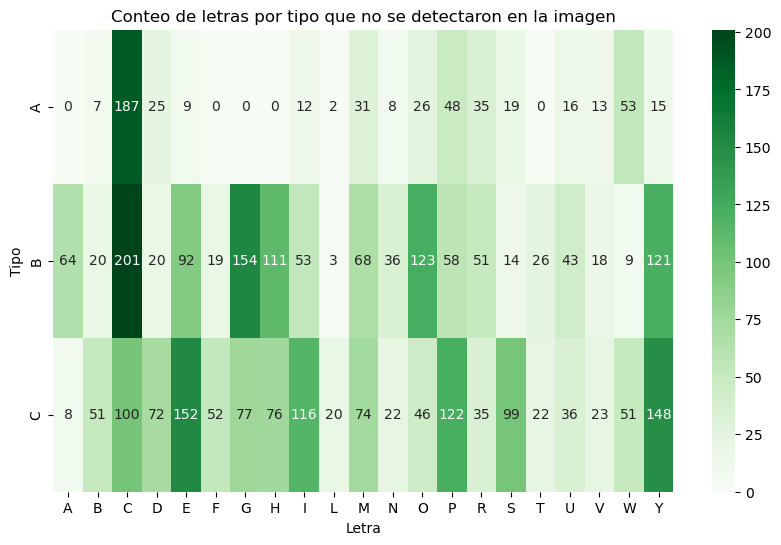

In [95]:
warning_heatmap(warning_train)

Llamada a la función para el conjunto de prueba

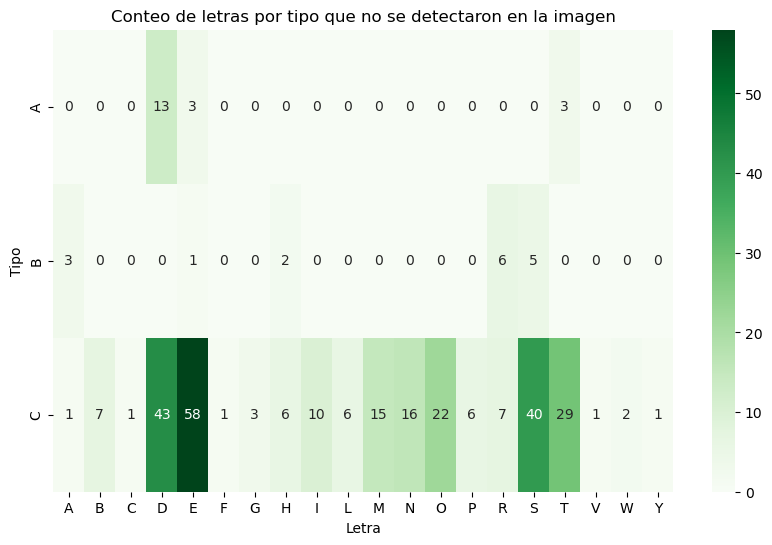

In [ ]:
warning_test = process_dataset(dataset_test_paths, 'dataset-test.csv', 'E:\\PC\\Limbo\\MSL-ABC\\MSL-ABC')
warning_heatmap(warning_test)

In [ ]:
warning_train = process_dataset(dataset_train_paths, 'dataset-train.csv', 'E:\\PC\\Limbo\\MSL-ABC\\MSL-ABC')

# Seleccion de caracteristicas


Para facilitar las pruebas, se utilizó la técnica StratifiedShuffleSplit para extraer una muestra balanceada de 50,000 registros del conjunto de datos original. Este subconjunto se guardó en el archivo dataset-train-reduced.csv, manteniendo la distribución proporcional de clases

In [82]:
# Carga el dataset completo desde un archivo CSV
df = pd.read_csv("dataset-train.csv")

# Separa las características (X) y la variable objetivo (y)
X = df.drop(columns=['LETRA'])
y = df['LETRA']

# Configura el muestreo estratificado para obtener un subconjunto balanceado
n_samples = 42000  # Número deseado de registros en la muestra
splitter = StratifiedShuffleSplit(n_splits=1, test_size=n_samples, random_state=42)

# Realiza el muestreo estratificado
for _, subset_index in splitter.split(X, y):
    df_sampled = df.iloc[subset_index]

# Guarda el subconjunto reducido en un nuevo archivo CSV
df_sampled.to_csv("dataset-train-reduced.csv", index=False)

distribucion_clases = df_sampled['LETRA'].value_counts()

C:\Users\Jesus\AppData\Local\Temp\ipykernel_9140\565889944.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




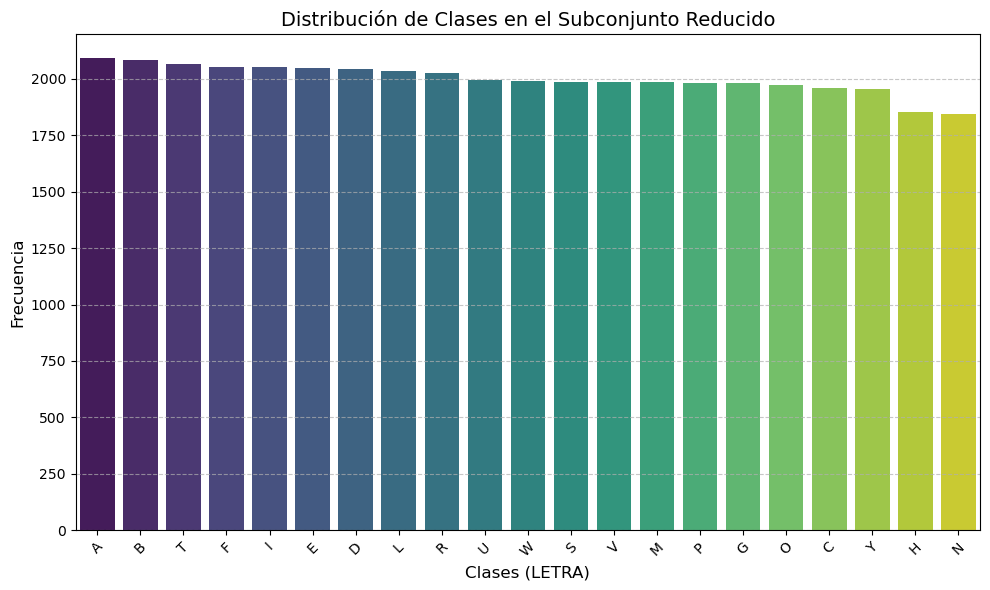

In [83]:
# Crear una gráfica de barras
plt.figure(figsize=(10, 6))
sns.barplot(x=distribucion_clases.index, y=distribucion_clases.values, palette="viridis")

# Etiquetas y título
plt.xlabel('Clases (LETRA)', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.title('Distribución de Clases en el Subconjunto Reducido', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Muestra la gráfica
plt.tight_layout()
plt.show()

Se codificaron las etiquetas de las letras en valores numéricos para facilitar su uso en los modelos de clasificación.

In [96]:
# Cargar el dataset
df = pd.read_csv("dataset-train-reduced.csv")

# Codificador
letter2encode = {'A': 0,'B': 1,'C': 2,'D': 3,'E': 4,'F': 5,'G': 6,'H': 7,'I': 8,'K': 9,'L': 10,'M': 11,
                'N': 12,'O': 13,'P': 14,'R': 15,'S': 16,'T': 17,'U': 18,'V': 19,'W': 20,'Y': 21}
df['LETRA'] = df['LETRA'].map(letter2encode)

# Separar características (X) y etiquetas (y)
X = df.drop(columns=['LETRA'])
y = df['LETRA']

Se aplicó el método de **información mutua** (`mutual_info_classif`) para calcular la relevancia de cada keypoint, considerando tanto sus componentes `x` como `y` en relación con la etiqueta de la clase.

Para cada keypoint, se calcularon por separado las importancias de los componentes `x` e `y`, y luego se ordenaron los keypoints según su relevancia combinada, que se obtuvo a partir de la suma de las importancias de los componentes `x` e `y`.


In [97]:
# Calcula la información mutua entre las características y la variable objetivo.
mi_scores = mutual_info_classif(X, y, random_state=42)

# Crea una Serie de pandas para los puntajes de información mutua, asignando como índices los nombres de las columnas originales.
# Luego, los ordena en orden descendente según su valor.
mi_series = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)

# Imprime los puntajes de información mutua por cada característica.
print("Información mutua por característica:")
print(mi_series)

# Inicializamos una lista vacía para un nuevo índice (aunque no se está usando en el código actual).
new_index = []

# Creamos un diccionario vacío donde sumaremos los valores de información mutua para cada par de keypoints (X y Y).
summed_data = {}

# Iteramos sobre los índices de la Serie ordenada para procesar cada característica.
for col in mi_series.index:
    base_name = col[:-2]  # Eliminamos los últimos 2 caracteres ('X' o 'Y') para obtener el nombre base del keypoint.

    # Si el nombre base no está en el diccionario, lo inicializamos con un valor de 0.
    if base_name not in summed_data:
        summed_data[base_name] = 0

    # Sumamos el puntaje de información mutua correspondiente al nombre base.
    summed_data[base_name] += mi_series[col]

# Creamos una nueva Serie a partir del diccionario, donde cada entrada representa la información mutua total para cada keypoint.
summed_series = pd.Series(summed_data)

summed_series = summed_series.sort_values(ascending=False) 


Información mutua por característica:
MIDDLE_TIP_Y    1.049929
MIDDLE_DIP_Y    0.946666
INDEX_TIP_Y     0.945586
RING_TIP_Y      0.877662
THUMB_CMC_Y     0.839372
MIDDLE_PIP_Y    0.804669
RING_DIP_Y      0.792100
INDEX_DIP_Y     0.779907
RING_PIP_Y      0.774927
THUMB_MCP_Y     0.721786
PINKY_TIP_Y     0.719960
WRIST_Y         0.708527
THUMB_TIP_Y     0.688770
RING_MCP_Y      0.671589
THUMB_IP_Y      0.663296
PINKY_DIP_Y     0.655155
PINKY_MCP_Y     0.636207
INDEX_PIP_Y     0.627896
PINKY_PIP_Y     0.624701
MIDDLE_MCP_Y    0.583417
INDEX_TIP_X     0.582028
PINKY_PIP_X     0.574915
MIDDLE_TIP_X    0.550169
THUMB_CMC_X     0.549124
RING_PIP_X      0.545842
THUMB_MCP_X     0.522219
PINKY_DIP_X     0.513107
THUMB_TIP_X     0.511971
PINKY_TIP_X     0.495045
INDEX_DIP_X     0.493220
THUMB_IP_X      0.492237
PINKY_MCP_X     0.483426
RING_MCP_X      0.463268
MIDDLE_DIP_X    0.449487
RING_DIP_X      0.447193
RING_TIP_X      0.439867
WRIST_X         0.429420
MIDDLE_PIP_X    0.423083
INDEX_MCP_Y 

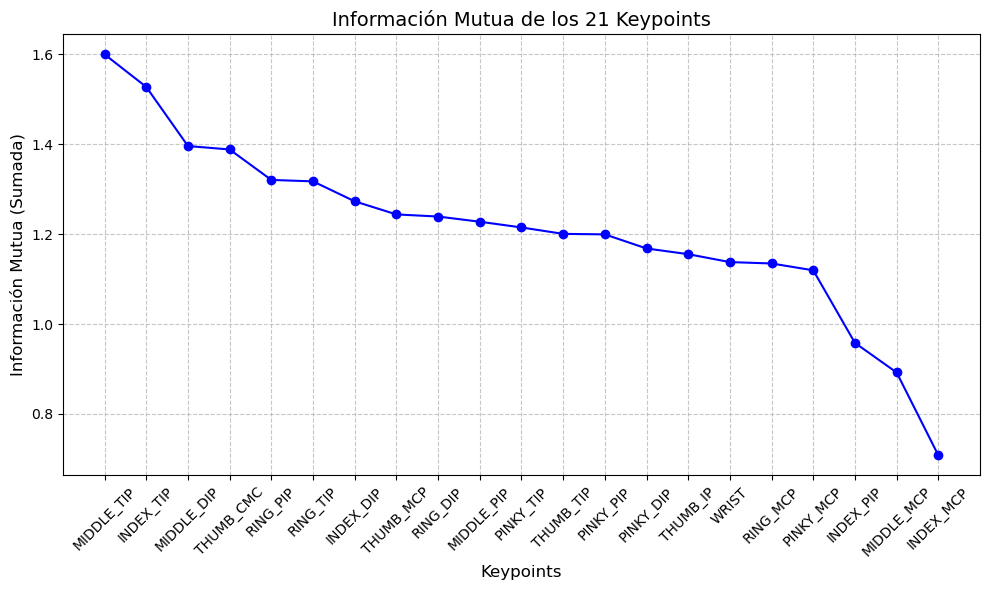

In [98]:
# Crear una gráfica de línea
plt.figure(figsize=(10, 6))
plt.plot(summed_series.index, summed_series.values, marker='o', linestyle='-', color='b')

# Etiquetas y título
plt.xlabel('Keypoints', fontsize=12)
plt.ylabel('Información Mutua (Sumada)', fontsize=12)
plt.title('Información Mutua de los 21 Keypoints', fontsize=14)
plt.xticks(rotation=45)
plt.grid(alpha=0.7, linestyle='--')

# Ajustar diseño y mostrar gráfica
plt.tight_layout()
plt.show()

# Experimento: ¿Qué conjunto de keypoints optimiza la precisión en la detección de letras estáticas de la Lengua de Señas Mexicana en sistemas de reconocimiento automatizado?

Para abordar la cuestión del conjunto mínimo de *keypoints* necesarios para una detección eficiente de letras estáticas en LSM, se utilizó un clasificador **Support Vector Classifier (SVC)** con parámetros por defecto y otro con un *kernel* polinomial de grado 3. 

El análisis se centró en distintos subconjuntos de características extraídas de las coordenadas $x$ e $y$ de los *keypoints* presentes en el archivo `dataset-train-reduced.csv`. Los subconjuntos fueron seleccionados utilizando el método de *información mutua*, y el número de *keypoints*  varió de 1 a 21, siguiendo el orden de relevancia indicado por dicho método.

## Evaluación de los Modelos
Para evaluar los modelos, se definieron dos funciones clave:
1. **Cálculo de la especificidad**, basado en la matriz de confusión.
2. **Obtención de métricas de desempeño**, que incluyen:
   - **F1 Macro**  
   - **Sensibilidad**  
   - **Especificidad**

La evaluación se realizó mediante validación cruzada, con particiones de $k = 5$ y $k = 10$.  

En cada iteración del experimento, se entrenaron y evaluaron ambos modelos (*SVC por defecto* y *SVC polinomial*) con diferentes números de características seleccionadas. Las métricas de desempeño se calcularon para cada caso, y los resultados se almacenaron en un DataFrame para su análisis posterior.

## Selección de Subconjuntos de Características
Se calculó la diferencia porcentual entre cada punto del *F1 Macro* para determinar:
- **Puntos de estabilización**: Donde el incremento en el *F1 Macro* es menor al 1% ($incremento < 1\%$).
- **Puntos de incremento significativo**: Donde el incremento es mayor al 1% ($incremento > 1\%$).

Estos puntos se usaron para identificar subconjuntos óptimos de características.


Esta función grafica varias métricas de rendimiento de un modelo en función de diferentes configuraciones, permitiendo visualizar cómo varían las métricas seleccionadas según el número de características o la configuración de validación cruzada. La función permite graficar las métricas de forma personalizada, según los parámetros proporcionados.


In [99]:
def plot_metrics_interactive(df, model_name, metrics=None, x_axis='num_features', cv_list=None):

    if metrics is None:
        metrics = ['f1_macro', 'sensitivity', 'specificity', 'train_time', 'predict_time']  # Métricas predeterminadas
    
    # Crear la figura principal
    fig = go.Figure()
    
    # Añadir un trazo para cada métrica
    for metric in metrics:
        if cv_list is None:
            # Si no hay configuraciones de validación cruzada, graficamos todos los datos juntos
            fig.add_trace(go.Scatter(
                x=df[x_axis],  # Configuración en el eje X
                y=df[metric],  # Valores de la métrica en el eje Y
                mode='lines+markers+text',  # Mostrar puntos, líneas y etiquetas
                name=metric,  # Nombre del trazo (aparece en la leyenda)
                text=[f"{m:.4f}" for m in df[metric]],  # Etiquetas con valores
                textposition='top center'  # Posición de las etiquetas
            ))
        else:
            # Si hay configuraciones de validación cruzada, graficamos por cada configuración
            for cv in cv_list:
                subset = df[df['cv'] == cv]  # Filtrar los datos por configuración de CV
                fig.add_trace(go.Scatter(
                    x=subset[x_axis],
                    y=subset[metric],
                    mode='lines+markers+text',
                    name=f'{metric} - CV={cv}',  # Agregar trazado al gráfico con el nombre de la métrica y la configuración
                    text=[f"{m:.4f}" for m in subset[metric]],  # Etiquetas de las métricas
                    textposition='top center'  # Posición de las etiquetas
                ))

    # Personalizar el diseño del gráfico
    fig.update_layout(
        title=f'{model_name} - Comparación de Métricas',  # Título del gráfico
        xaxis_title='Configuración',  # Título del eje X
        yaxis_title='Valor de Métrica',  # Título del eje Y
        template='plotly_white',  # Estilo visual
        showlegend=True,  # Mostrar leyenda
    )
    
    # Mostrar el gráfico
    fig.show()

In [ ]:
# Definir función para calcular la especificidad (proporción de verdaderos negativos entre todos los negativos reales)
def specificity(y_true, y_pred):
    # Calcular la matriz de confusión
    cm = confusion_matrix(y_true, y_pred)

    # Extraer la suma de los verdaderos negativos (diagonal de la matriz de confusión)
    tn = np.diag(cm).sum()

    # Calcular los falsos positivos (columna sumada de la matriz de confusión menos la diagonal)
    fp = cm.sum(axis=0) - np.diag(cm)

    # Calcular la especificidad para cada clase, ignorando los errores de división por cero
    with np.errstate(divide='ignore', invalid='ignore'):
        specificity_scores = np.where((tn + fp) != 0, tn / (tn + fp), 0)

    # Retornar la media de los puntajes de especificidad
    return np.mean(specificity_scores)

# Definir función para obtener las métricas con validación cruzada
def get_metrics(estimator, X, y, cv):
    # Definir las métricas a evaluar durante la validación cruzada (f1_macro, sensibilidad, especificidad)
    scoring = {
        'f1_macro': make_scorer(f1_score, average='macro'),
        'sensitivity': make_scorer(recall_score, average='macro'),
        'specificity': make_scorer(specificity)
    }

    # Realizar la validación cruzada con las métricas definidas
    results = cross_validate(estimator, X, y, scoring=scoring, cv=cv, return_train_score=False, n_jobs=-1)

    # Calcular el tiempo promedio de entrenamiento utilizando 'fit_time'
    train_time = np.mean(results['fit_time'])

    print(f"Tiempo promedio de entrenamiento: {train_time:.4f} segundos")

    # Retornar las métricas promedio y el tiempo de entrenamiento
    return {
        'f1_macro': np.mean(results['test_f1_macro']),
        'sensitivity': np.mean(results['test_sensitivity']),
        'specificity': np.mean(results['test_specificity']),
        'train_time': train_time,
    }

# Obtener lista de nombres de las características (features) ordenados por su información mutua
features_order = summed_series.index.tolist()

# Preparar listas para almacenar los resultados de las métricas para el modelo
metrics_svc_poly = []
cv_list = [5, 10]  # Definir las configuraciones de validación cruzada a usar

# Definir el modelo SVC con sus configuraciones
svc_poly = SVC(kernel='poly', degree=3, random_state=42, cache_size=2000)

# Ciclo que evalúa desde 1 hasta 21 características seleccionadas y sus correspondientes columnas X e Y
for num_features in range(1, len(features_order) + 1):
    # Seleccionar las primeras 'num_features' características
    selected_features = features_order[:num_features]
    feature_columns = [f"{feat}_{axis}" for feat in selected_features for axis in ['X', 'Y']]  # Combinar cada característica con su eje (X, Y)

    # Filtrar las columnas necesarias para las características seleccionadas
    X = df[feature_columns]
    y = df['LETRA']  # Variable objetivo

    # Realizar la validación cruzada para cada configuración de CV
    for cv in cv_list:
        print(f"\n[INFO] Iniciando evaluación con {num_features} características y CV={cv}")
        start_time = time.strftime('%H:%M:%S', time.localtime())  # Registrar el inicio del proceso
        print(f"Inicio SVC Poly: {start_time}")

        # Evaluar el modelo SVC con kernel polinomial
        metrics_poly = get_metrics(svc_poly, X, y, cv)
        metrics_poly['num_features'] = num_features
        metrics_poly['cv'] = cv
        metrics_svc_poly.append(metrics_poly)  # Almacenar los resultados
        end_time = time.strftime('%H:%M:%S', time.localtime())
        print(f"Finalizado SVC Poly: {end_time}")

# Convertir los resultados obtenidos en DataFrames para un análisis posterior
df_poly = pd.DataFrame(metrics_svc_poly)



In [102]:
# Graficar las métricas
plot_metrics_interactive(df_poly, 'SVC Poly',metrics=['f1_macro', 'sensitivity', 'specificity'], cv_list=cv_list)

## Evaluación Final en Conjunto de Prueba
Para finalizar, se realizó un entrenamiento completo con 41,000 datos utilizando:
1. Todos los datos de entrenamiento disponibles.
2. Subconjuntos específicos de características seleccionadas en el análisis previo.  

El desempeño de los modelos se evaluó en el conjunto de prueba para comparar el impacto de los subconjuntos en la precisión y eficiencia del modelo.

In [103]:
# Cargar el dataset
df_test = pd.read_csv("dataset-test.csv")

# Codificador
letter2encode = {'A': 0,'B': 1,'C': 2,'D': 3,'E': 4,'F': 5,'G': 6,'H': 7,'I': 8,'K': 9,'L': 10,'M': 11,
                'N': 12,'O': 13,'P': 14,'R': 15,'S': 16,'T': 17,'U': 18,'V': 19,'W': 20,'Y': 21}
df_test['LETRA'] = df_test['LETRA'].map(letter2encode)

# Separar características (X) y etiquetas (y)
X_test = df_test.drop(columns=['LETRA'])
y_test = df_test['LETRA']

Este bloque de código permite decodificar la matriz de confusión, reemplazando los índices numéricos por sus correspondientes letras según el diccionario de codificación.

In [104]:
# Diccionario para mapear códigos numéricos a letras
encode2letter = {v: k for k, v in letter2encode.items()}

# Función para descodificar la matriz de confusión
def decode_confusion_matrix(conf_matrix, encode2letter):
    # Convertir la matriz de NumPy a un DataFrame
    decoded_matrix = pd.DataFrame(conf_matrix)
    # Renombrar las filas y columnas con las letras correspondientes
    decoded_matrix = decoded_matrix.rename(index=encode2letter, columns=encode2letter)
    return decoded_matrix

Este bloque de código calcula las diferencias porcentuales entre valores consecutivos de F1 Macro para identificar puntos donde hay incrementos significativos o estabilización.

In [105]:
# Extraer los valores de F1 Macro desde el DataFrame de resultados
f1_macro_scores = df_poly[df_poly['cv'] == 10]['f1_macro'].reset_index(drop=True)

# Imprimir los valores de las características y sus correspondientes puntajes F1 Macro
print("Valores de num_features:", num_features)
print("Valores de f1_macro_scores:")
print(f1_macro_scores)

# Calcular la diferencia porcentual entre cada par de valores consecutivos de F1 Macro
diff_f1_macro = np.diff(f1_macro_scores) / f1_macro_scores[:-1] * 100

# Definir un umbral para identificar mejoras significativas en F1 Macro (> 1%)
threshold = 1.0

# Identificar los puntos donde el incremento porcentual de F1 Macro es significativo (> 1%)
# np.diff reduce el tamaño del arreglo en 1, así que se ajusta el índice sumando +1
significant_increases = np.where(diff_f1_macro > threshold)[0] + 1
print("Puntos con incrementos significativos:", significant_increases)

# Determinar el punto de estabilización, donde el incremento porcentual es menor al umbral (< 1%)
stabilization_point = np.where(diff_f1_macro < threshold)[0]
if len(stabilization_point) > 0:
    # Si se encuentra un punto, tomar el primer índice como referencia
    stabilization_point = stabilization_point[0] + 1
else:
    # Si no se estabiliza, tomar el máximo número de características
    stabilization_point = len(f1_macro_scores)

print(f"Estabilización del rendimiento a partir de: {stabilization_point} características")

Valores de num_features: 21
Valores de f1_macro_scores:
0     0.362403
1     0.723258
2     0.795157
3     0.835505
4     0.904981
5     0.931660
6     0.938381
7     0.950839
8     0.956620
9     0.958734
10    0.962713
11    0.974808
12    0.976971
13    0.977458
14    0.977714
15    0.978388
16    0.979384
17    0.980707
18    0.981180
19    0.982003
20    0.982844
Name: f1_macro, dtype: float64
Puntos con incrementos significativos: [ 1  2  3  4  5  7 11]
Estabilización del rendimiento a partir de: 6 características


Esta función grafica las matrices de confusión de un modelo, permitiendo visualizar los resultados de las predicciones frente a las etiquetas reales. La matriz de confusión es decodificada y se muestra con un formato visual adecuado para una mejor interpretación de los resultados del modelo.

In [106]:
def plot_confusion_matrix(df, model_name, title_column='params'):
    num_matrices = len(df)  # Número de matrices a graficar
    fig, axes = plt.subplots(1, num_matrices, figsize=(8 * num_matrices, 8))  # Incrementar tamaño del gráfico
    
    # Asegúrate de que `axes` sea un iterable (incluso con una sola matriz)
    if num_matrices == 1:
        axes = [axes]
    
    for i, (index, row) in enumerate(df.iterrows()):
        confusion_matrix_result = row['confusion_matrix']
        
        # Decodificar la matriz de confusión
        decoded_matrix = decode_confusion_matrix(confusion_matrix_result, encode2letter)
        
        # Calcular tamaño de la fuente según la cantidad de celdas
        matrix_size = decoded_matrix.shape[0]
        cell_size = 8 * num_matrices / matrix_size  # Relación entre tamaño de gráfica y celdas
        font_size = max(8, cell_size * 0.5)  # Escalar tamaño de fuente
        
        # Graficar la matriz de confusión descodificada
        sns.heatmap(decoded_matrix, annot=True, fmt='d', cmap='Greens',
                    xticklabels=encode2letter.values(), yticklabels=encode2letter.values(),
                    ax=axes[i], annot_kws={"size": font_size})  # Tamaño de anotaciones dinámico
        axes[i].set_title(f'Matriz de Confusión - {model_name}\n{row[title_column]} características')
        axes[i].set_xlabel('Predicción')
        axes[i].set_ylabel('Real')

    # Ajustar espacio entre gráficos
    plt.tight_layout()
    plt.show()


Esta función obtiene las métricas de rendimiento de un modelo al evaluarlo sobre un conjunto de prueba que nunca ha sido visto por el modelo durante el entrenamiento. Calcula diversas métricas como la precisión, sensibilidad y especificidad, así como los tiempos de entrenamiento y predicción, y devuelve estos resultados junto con la matriz de confusión.

In [107]:
# Definir función para obtener las métricas con validación cruzada
def get_metrics_test(estimator, X, y, X_test, y_test):
    # Medir el tiempo de entrenamiento
    start_train_time = time.time()
    # Ajustar el modelo SVC con los datos de entrenamiento
    estimator.fit(X, y)
    end_train_time = time.time()
    train_time = end_train_time - start_train_time

    # Medir el tiempo de predicción
    start_predict_time = time.time()
    # Realizar predicciones sobre el conjunto de prueba
    y_pred = estimator.predict(X_test)
    end_predict_time = time.time()
    predict_time = end_predict_time - start_predict_time
    
    # Calcular las métricas
    confusion_matrix_result = confusion_matrix(y_test, y_pred)
    f1_macro_score = f1_score(y_test, y_pred, average='macro')
    sensitivity_score = recall_score(y_test, y_pred, average='macro')
    specificity_score = specificity(y_test, y_pred)

    # Retornar las métricas
    return {
        'f1_macro': f1_macro_score,
        'sensitivity': sensitivity_score,
        'specificity': specificity_score,
        'confusion_matrix': confusion_matrix_result,
        'train_time': train_time,
        'predict_time': predict_time
    }

In [108]:
# Preparar listas para almacenar los resultados de las métricas para el modelo SVC polinomial
metrics_svc_poly = []

# Definir el modelo SVC con sus configuraciones
svc_poly = SVC(kernel='poly', cache_size=2000, random_state=42)  

#Datos de incremento significado mas el de características totales
significante = np.append(significant_increases, 21)

# Ciclo que evalúa características seleccionadas y sus correspondientes columnas X e Y donde el incremento porcentual de F1 Macro es significativo (> 1%) ademas de el de todos los keypoints
for num_features in significante:
    # Seleccionar las primeras 'num_features' características
    selected_features = features_order[:num_features]
    feature_columns = [f"{feat}_{axis}" for feat in selected_features for axis in ['X', 'Y']]  # Combinar cada característica con su eje (X, Y)

    # Filtrar las columnas necesarias para las características seleccionadas
    # Separa las características (X) y la variable objetivo (y)
    X = df[feature_columns]
    y = df['LETRA']

    # Separar características (X) y etiquetas (y)
    X_test = df_test[feature_columns]
    y_test = df_test['LETRA']


    print(f"\n[INFO] Iniciando evaluación con {num_features} características")
    start_time = time.strftime('%H:%M:%S', time.localtime())  # Registrar el inicio del proceso
    print(f"Inicio SVC Poly: {start_time}")

    # Evaluar el modelo SVC con kernel polinomial
    metrics_poly = get_metrics_test(svc_poly, X, y, X_test, y_test)
    metrics_poly['num_features'] = num_features
    metrics_svc_poly.append(metrics_poly)  # Almacenar los resultados
    end_time = time.strftime('%H:%M:%S', time.localtime())
    print(f"Finalizado SVC Poly: {end_time}")

# Convertir los resultados obtenidos en DataFrames para un análisis posterior
df_poly = pd.DataFrame(metrics_svc_poly)


[INFO] Iniciando evaluación con 1 características
Inicio SVC Poly: 21:32:12
Finalizado SVC Poly: 21:36:49

[INFO] Iniciando evaluación con 2 características
Inicio SVC Poly: 21:36:49
Finalizado SVC Poly: 21:38:36

[INFO] Iniciando evaluación con 3 características
Inicio SVC Poly: 21:38:36
Finalizado SVC Poly: 21:40:05

[INFO] Iniciando evaluación con 4 características
Inicio SVC Poly: 21:40:05
Finalizado SVC Poly: 21:41:12

[INFO] Iniciando evaluación con 5 características
Inicio SVC Poly: 21:41:12
Finalizado SVC Poly: 21:42:03

[INFO] Iniciando evaluación con 7 características
Inicio SVC Poly: 21:42:03
Finalizado SVC Poly: 21:42:43

[INFO] Iniciando evaluación con 11 características
Inicio SVC Poly: 21:42:43
Finalizado SVC Poly: 21:43:16

[INFO] Iniciando evaluación con 21 características
Inicio SVC Poly: 21:43:16
Finalizado SVC Poly: 21:43:39


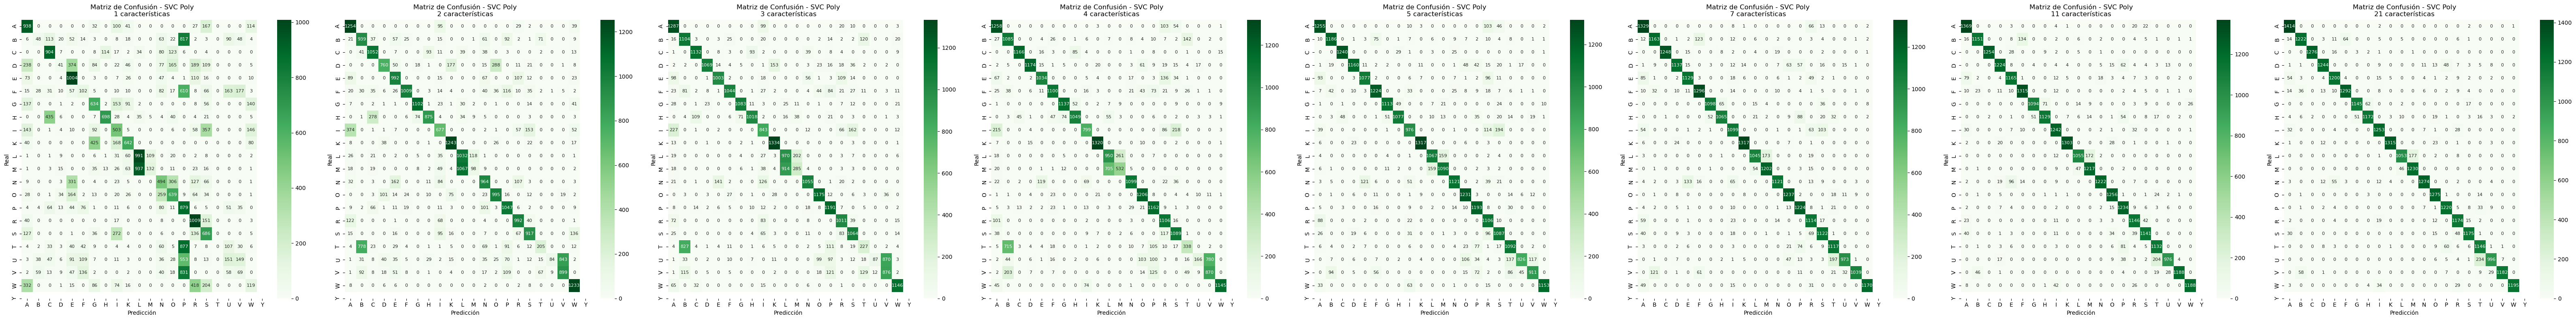

In [109]:
# Graficar las métricas
plot_metrics_interactive(df_poly, 'SVC Poly')
plot_confusion_matrix(df_poly, 'SVC Poly', 'num_features')

# ¿Cuáles son los hiperparámetros óptimos del modelo SVM con kernel polinomial para la clasificación de letras estáticas en la Lengua de Señas Mexicana?

Para la selección de los hiperparámetros óptimos del modelo SVM con kernel polinomial, se utilizó la técnica de **GridSearchCV**, un enfoque basado en validación cruzada que evalúa exhaustivamente todas las combinaciones posibles de un conjunto predefinido de valores para cada hiperparámetro.

En este caso, el espacio de búsqueda incluyó tres hiperparámetros: 

- **`degree`**: controla el grado del polinomio en el kernel, evaluado en el rango de 2 a 6.  
- **`C`**: regula la complejidad del modelo y controla el balance entre el sobreajuste y el subajuste, con valores en el rango de 0.1 a 1000.  
- **`gamma`**: determina la influencia de un único ejemplo de entrenamiento en la decisión del modelo. Se utilizaron dos valores:  
  - `auto`: calcula el valor como \( \frac{1}{n \text{ características}} \).  
  - `scale`: calcula el valor como \( \frac{1}{n \text{ características} \times \text{varianza de } X} \).  

GridSearchCV optimiza estos hiperparámetros para encontrar la combinación que maximice el rendimiento del modelo, permitiendo así una mejor generalización a nuevos datos. Para este caso, se utilizaron los **21 keypoints** disponibles.


In [ ]:
# Definir el modelo SVC con el kernel polinomial
svc_poly = SVC(kernel='poly', random_state=42, cache_size=2000)


# Definir el rango de hiperparámetros que deseas probar
param_grid = {
    'degree': [2, 3, 4, 5, 6],       # Grados polinomiales
    'C': [0.1, 1, 10, 100, 1000],    # Regularización 
    'gamma': ['auto', 'scale']       # Gamma 
}


# Crear el objeto GridSearchCV
grid_search = GridSearchCV(
    estimator=svc_poly,
    param_grid=param_grid,
    scoring='f1_macro',
    cv=5,
    n_jobs=-1,
    verbose=4,
    return_train_score=True  # Retorna también los puntajes del entrenamiento
)

# Entrena el modelo con los datos (X e y)
grid_search.fit(X, y)


# Ordenar los resultados y obtener los cinco mejores basados en 'mean_test_score'
top_5_results = sorted(
    zip(grid_search.cv_results_['mean_test_score'], grid_search.cv_results_['params']),
    key=lambda x: x[0],  # Ordenar por el puntaje (primer elemento de cada tupla)
    reverse=True  # Orden descendente
)[:5]

# Mostrar las cinco mejores combinaciones de parámetros y sus scores
for i, (score, params) in enumerate(top_5_results, start=1):
    print(f"Top {i}:")
    print(f"  Parámetros: {params}")
    print(f"  F1 Macro: {score}")
    print("-" * 30)
# Convertir los resultados a un DataFrame para la visualización
results_df = pd.DataFrame(grid_search.cv_results_)

# Filtrar las columnas relevantes
results_df = results_df[['param_degree', 'param_C', 'param_gamma', 'mean_test_score']]
results_df.columns = ['degree', 'C', 'gamma', 'f1_macro']


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Top 1:
  Parámetros: {'C': 0.1, 'degree': 5, 'gamma': 'scale'}
  F1 Macro: 0.9874577038803263
------------------------------
Top 2:
  Parámetros: {'C': 100, 'degree': 3, 'gamma': 'scale'}
  F1 Macro: 0.9871169321548627
------------------------------
Top 3:
  Parámetros: {'C': 10, 'degree': 4, 'gamma': 'scale'}
  F1 Macro: 0.9869933275227549
------------------------------
Top 4:
  Parámetros: {'C': 1, 'degree': 4, 'gamma': 'scale'}
  F1 Macro: 0.9869310055616175
------------------------------
Top 5:
  Parámetros: {'C': 0.1, 'degree': 6, 'gamma': 'scale'}
  F1 Macro: 0.9868604429830509
------------------------------


In [ ]:

# Crear una gráfica 3D para visualizar los resultados de GridSearchCV
fig = go.Figure()

# Agregar un scatter 3D
fig.add_trace(go.Scatter3d(
    x=results_df['C'],
    y=results_df['degree'],
    z=results_df['gamma'],
    mode='markers',
    marker=dict(
        size=10,
        color=results_df['f1_macro'],  # Colorear según el grado
        colorscale='Viridis',  # Escala de color para mejor visibilidad
        colorbar=dict(title='F1 Macro'),
        opacity=0.8
    ),
    text=[f"Degree: {d}, C: {c}, Gamma: {g}, F1 Macro: {f1:.4f}"
          for d, c, g, f1 in zip(results_df['degree'], results_df['C'], results_df['gamma'], results_df['f1_macro'])],
    hoverinfo='text'
))

# Personalizar el diseño del gráfico
fig.update_layout(
    scene=dict(
        xaxis=dict(title='Regularization (C)', type='log'),
        yaxis=dict(title='Polynomial Degree'),
        zaxis=dict(title='Gamma'),
    ),
    title='Resultados de GridSearchCV para SVC con Kernel Polinomial (Gráfica 3D)',
    template='plotly_white'
)

# Mostrar la gráfica interactiva
fig.show() 

Al  finalizar se realizó un entrenamiento completo con todos los datos de entrenamiento disponibles (42,000 ya que el tiempo de ejecución con los xxxxxxx valores no era computacionalmente posible en este proyecto) , y se evaluó el desempeño en el conjunto de prueba. Esto se repitió utilizando subconjuntos específicos de keypoints obtenidas del punto anterior para comparar su impacto en la precisión del modelo.

In [ ]:
top_5_results = sorted(
    zip(grid_search.cv_results_['mean_test_score'], grid_search.cv_results_['params']),
    key=lambda x: x[0],  # Ordenar por el puntaje (primer elemento de cada tupla)
    reverse=True  # Orden descendente
)[:5]

# Agregar una tupla con score = 0 y params = {} al principio de la lista
top_5_results.insert(0, (0, {}))

# Preparar listas para almacenar los resultados de las métricas para el modelo SVC polinomial
metrics_svc_poly = []

for i, (score, params) in enumerate(top_5_results, start=1):
    
    # Definir el modelo SVC con sus configuraciones
    svc_poly = SVC(kernel='poly', cache_size=2000, random_state=42, **params)

    # Filtrar las columnas necesarias para las características seleccionadas
    X = df.drop(columns=['LETRA'])
    y = df['LETRA']  # Variable objetivo

    # Separar características (X) y etiquetas (y)
    X_test = df_test.drop(columns=['LETRA'])
    y_test = df_test['LETRA']


    print(f"\n[INFO] Evaluando configuración {i-1}: {params}")
    start_time = time.strftime('%H:%M:%S', time.localtime())  # Registrar el inicio del proceso
    print(f"Inicio SVC Poly: {start_time}")

    # Evaluar el modelo SVC con kernel polinomial
    metrics_poly = get_metrics_test(svc_poly, X, y, X_test, y_test)
    metrics_poly['params'] = params
    metrics_svc_poly.append(metrics_poly)  # Almacenar los resultados
    end_time = time.strftime('%H:%M:%S', time.localtime())
    print(f"Finalizado SVC Poly: {end_time}")

# Convertir los resultados obtenidos en DataFrames para un análisis posterior
df_poly = pd.DataFrame(metrics_svc_poly)

# Crear una columna para numerar las filas
df_poly['x_index'] = range(0, len(df_poly))

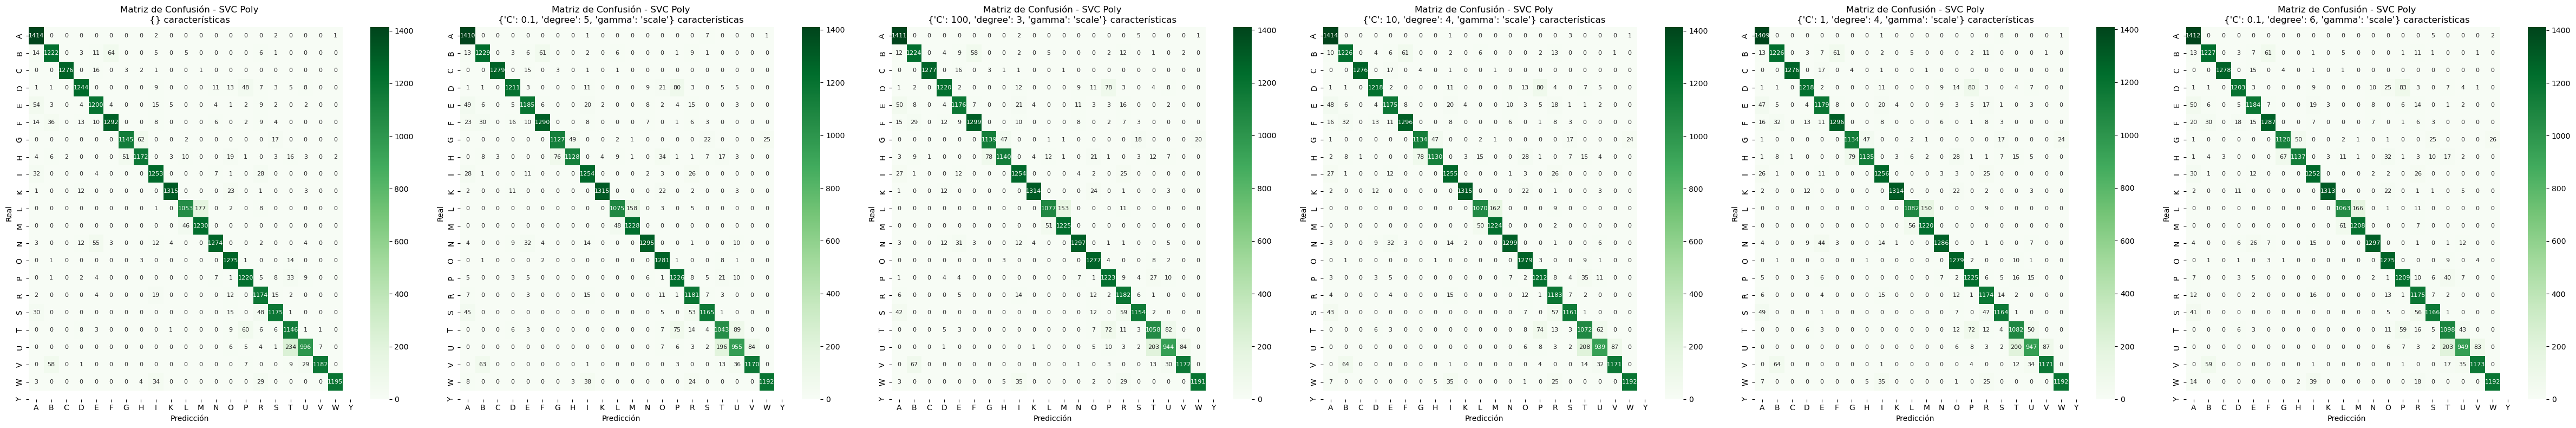

In [112]:
# Graficar las métricas
plot_metrics_interactive(df_poly, 'SVC Poly', x_axis='x_index')
plot_confusion_matrix(df_poly, 'SVC Poly')